<a href="https://colab.research.google.com/github/nulllpointer/custom_object_detection_colab/blob/master/objdet_custom_tf_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tensorflow Object Detection with custom dataset in Google Colab

Jupyter notebook providing steps to retrain a [ModelZoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) model with custom dataset.

It runs in [Google Colab](https://colab.research.google.com) using [Tensorflow Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection).

**Requirements are only dataset images and annotations file.**

**Colab Runtime type: Python2, GPU enabled.**

**creater: Hitesh Jha(github.com/nulllpointer)


#Create Dataset

I generated dataset annotations with [LabelImg](https://github.com/tzutalin/labelImg).

Notebook train a model for one class object detection. It is possible to slightly modify notebook to train model for multiple classes.

Before running notebook, we need to create dataset:

1.   Collect various pictures of objects to detect
2.   Rename image filenames with format `objectclass_seq.jpg`
3.   In LabelImg create annotation files. LabelImg saves annotations as XML files in PASCAL VOC format
4.   Create dataset.zip file having structure defined below
5.   Upload the zip file in your Google Drive

Zip file structure:
```
dataset.zip file
|-images directory
  |-image files (filename format: objectclass_seq.jpg)
|-annotations directory
  |-xmls directory
    |-annotation files (filename format: objectclass_seq.xml)
```

Where `objectclass` is the class name, `seq` is a sequence number (001, 002, 003, ...)

Check my dataset.zip file as dataset example.


# Install required packages


In [69]:
%cd

# Create Data workspace  
%mkdir -p ~/datalab 
#  run initially 
!git clone --quiet https://github.com/tensorflow/models.git

!apt-get install -qq protobuf-compiler python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib PyDrive

!pip install -q pycocotools
import os

#Move config file if it exists
%cd ..
![ -f pipeline.config ] && mv pipeline.config /root/datalab

config = {
    'FILE_ID' : '1GYWEfS1Wr_unkzKLYVgioTfpm9BVhpGT',
    'MODEL' : 'faster_rcnn_inception_v2_coco_2018_01_28',
    'DOWNLOAD_BASE' : 'http://download.tensorflow.org/models/object_detection/',
    'DEST_DIR' : 'pretrained_model',
    'PATH_TO_BE_CONFIGURED' : '~/datalab',
    #import your pipeline configuration inside datalab directory
    'PIPELINE_CONFIG_FILE' : 'pipeline.config',
    
    'PATH_TO_CKPT' : '/root/datalab/fine_tuned_model' + '/frozen_inference_graph.pb',
    'PATH_TO_LABELS' : '/root/datalab'+ '/label_map.pbtxt',
    'NUM_CLASSES' : str(37)

          }

#Setting environment
os.environ['PYTHONPATH'] += ':/root/models/research/:/root/models/research/slim/setup.py'
os.environ['PYTHONPATH'] += ':/root/models/research/:/root/models/research/slim'
os.environ['FILE_ID'] = config["FILE_ID"]
os.environ['MODEL'] = config['MODEL']
os.environ['DOWNLOAD_BASE'] = config['DOWNLOAD_BASE']
os.environ['DEST_DIR'] = config['DEST_DIR']
os.environ['PATH_TO_BE_CONFIGURED'] = config['PATH_TO_BE_CONFIGURED']
os.environ['PIPELINE_CONFIG_FILE'] = config['PIPELINE_CONFIG_FILE']

os.environ['PATH_TO_CKPT'] = config['PATH_TO_CKPT']
os.environ['PATH_TO_LABELS'] = config['PATH_TO_LABELS']
os.environ['NUM_CLASSES'] = config['NUM_CLASSES']


%cd ~/models/research
!protoc object_detection/protos/*.proto --python_out=.
!python object_detection/builders/model_builder_test.py

import os
from zipfile import ZipFile
from shutil import copy
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#Get the dataset file ID by sharing link in google drive
# fileId = '1GYWEfS1Wr_unkzKLYVgioTfpm9BVhpGT'
fileId= os.environ.get('FILE_ID')

fileName = fileId + '.zip'
downloaded = drive.CreateFile({'id': fileId})
downloaded.GetContentFile(fileName)
ds = ZipFile(fileName)
ds.extractall()
os.remove(fileName)
print('Extracted zip file ' + fileName)

image_files=os.listdir('images')
im_files=[x.split('.')[0] for x in image_files]
with open('annotations/trainval.txt', 'w') as text_file:
  for row in im_files:
    text_file.write(row + '\n')
%cd ~/datalab/annotations
!mkdir -p trimaps

from PIL import Image
image = Image.new('RGB', (640, 480))

for filename in os.listdir('xmls'):
  filename = os.path.splitext(filename)[0]
  image.save('trimaps/' + filename + '.png')
%cd ~/datalab

!python ~/models/research/object_detection/dataset_tools/create_pet_tf_record.py --label_map_path=label_map.pbtxt --data_dir=. --output_dir=. --num_shards=1

!mv pet_faces_train.record-00000-of-00001 tf_train.record

!mv pet_faces_val.record-00000-of-00001 tf_val.record

%cd ~/datalab

import os
import shutil
import glob
import urllib
import tarfile

# MODEL = 'faster_rcnn_inception_v2_coco_2018_01_28'
# MODEL_FILE = MODEL + '.tar.gz'
# DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
# DEST_DIR = 'pretrained_model'

MODEL = os.environ.get('MODEL')
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = os.environ.get('DOWNLOAD_BASE')
DEST_DIR = os.environ.get('DEST_DIR')


if not (os.path.exists(MODEL_FILE)):
  opener = urllib.URLopener()
  opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
  shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)
# Uploading files to directory
# %cd ~
# %cd ..
# !ls

# check this
# !mv pipeline.config /root/datalab

!pwd

%cd ~/datalab

!ls


import re
# PATH_TO_BE_CONFIGURED='~/datalab'
PATH_TO_BE_CONFIGURED=os.environ.get('PATH_TO_BE_CONFIGURED')


filename = 'pipeline.config'

# filename = os.environ.get('PIPELINE_CONFIG_FILE')



# filename = '/root/models/research/object_detection/samples/configs/faster_rcnn_inception_v2_pets.config'
with open(filename) as f:
  s = f.read()
with open(filename, 'w') as f:
  s = re.sub('PATH_TO_BE_CONFIGURED/model.ckpt', '/root/datalab/pretrained_model/model.ckpt', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/pet_faces_train.record-\?\?\?\?\?-of-00010', '/root/datalab/tf_train.record', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/pet_faces_val.record-\?\?\?\?\?-of-00010', '/root/datalab/tf_val.record', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/pet_label_map.pbtxt', '/root/datalab/label_map.pbtxt', s)
  f.write(s)

%cd ~/datalab
!pwd


!python ~/models/research/object_detection/model_main.py \
    --pipeline_config_path=pipeline.config \
    --model_dir=trained \
    --alsologtostderr \
    --num_train_steps=3000 \
    --num_eval_steps=500




%cd ~/datalab

lst = os.listdir('trained')
lf = filter(lambda k: 'model.ckpt-' in k, lst)
last_model = sorted(lf)[-1].replace('.meta', '')




!python ~/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=pipeline.config \
    --output_directory=fine_tuned_model \
    --trained_checkpoint_prefix=trained/$last_model


/root
fatal: destination path 'models' already exists and is not an empty directory.
/
/root/models/research
W0717 18:46:59.817801 140518241458048 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0717 18:46:59.938524 140518241458048 deprecation_wrapper.py:119] From /root/models/research/slim/nets/inception_resnet_v2.py:373: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0717 18:46:59.944921 140518241458048 deprecation_wrapper.py:119] From /root/models/research/slim/nets/mobilenet/mobilenet.py:397: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

Running tests under Python 2.7.15: /usr/bin/pytho

W0717 18:47:01.053776 140274862339968 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth
Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/googleapiclient/discovery_cache/__init__.py", line 41, in autodetect
    from . import file_cache
  File "/usr/local/lib/python2.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 41, in <module>
    'file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth')
ImportError: file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth


Extracted zip file 1GYWEfS1Wr_unkzKLYVgioTfpm9BVhpGT.zip
/root/datalab/annotations
/root/datalab
W0717 18:47:07.296663 139840190773120 deprecation_wrapper.py:119] From /root/models/research/object_detection/dataset_tools/create_pet_tf_record.py:318: The name tf.app.run is deprecated. Please use tf.compat.v1.app.run instead.

W0717 18:47:07.297369 139840190773120 deprecation_wrapper.py:119] From /root/models/research/object_detection/utils/label_map_util.py:137: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

I0717 18:47:07.298410 139840190773120 create_pet_tf_record.py:273] Reading from Pet dataset.
I0717 18:47:07.298845 139840190773120 create_pet_tf_record.py:288] 35 training and 15 validation examples.
W0717 18:47:07.299020 139840190773120 deprecation_wrapper.py:119] From /root/models/research/object_detection/dataset_tools/tf_record_creation_util.py:43: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.

I0717 1

/root/datalab


Saving dog.jpeg to dog (3).jpeg
saved file dog.jpeg
/root/models/research/object_detection


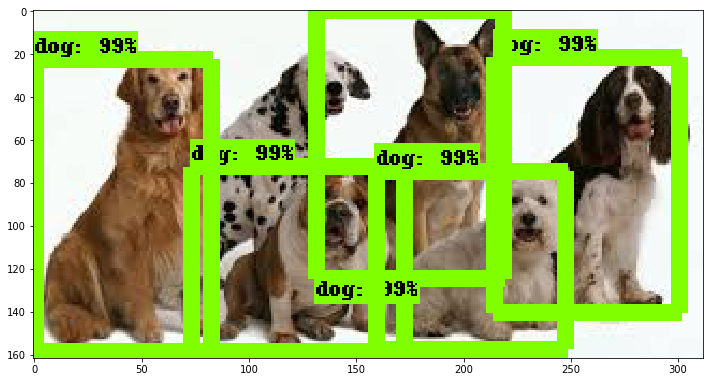

In [70]:

%cd ~/datalab

from google.colab import files
from os import path

uploaded = files.upload()
  
for name, data in uploaded.items():
  with open('image1.jpg', 'wb') as f:
    f.write(data)
    f.close()
    print('saved file ' + name)
%cd ~/models/research/object_detection




import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

# if tf.__version__ < '1.4.0':
#   raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')
  

  
  
# This is needed to display the images.
%matplotlib inline




from utils import label_map_util

from utils import visualization_utils as vis_util




# What model to download.
# Path to frozen detection graph. This is the actual model that is used for the object detection.
# PATH_TO_CKPT = '/root/datalab/fine_tuned_model' + '/frozen_inference_graph.pb'
# PATH_TO_LABELS = os.path.join('/root/datalab', 'label_map.pbtxt')

# NUM_CLASSES = 37



PATH_TO_CKPT = os.environ.get('PATH_TO_CKPT')
PATH_TO_LABELS = os.environ.get('PATH_TO_LABELS')
NUM_CLASSES = os.environ.get('NUM_CLASSES')



# List of the strings that is used to add correct label for each box.




detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
    
    
    
    
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)




def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)




# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '/root/datalab/'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 2) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)




def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict




for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)
  